In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
sys.path.append(os.path.join(module_path, 'cnn-keras'))

In [2]:
import fs
import datetime

from transformation import get_normalization_transform
from MiniBatchGenerator import MiniBatchGenerator

from keras.models import load_model
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils
import keras.backend as K

import PIL
from PIL import Image

import utils
import models

%matplotlib inline

Using Theano backend.
WARNING (theano.sandbox.cuda): CUDA is installed, but device gpu0 is not available  (error: Unable to get the number of gpus available: unknown error)


In [3]:
def deprocess(data):
    return data.transpose((2,1,0)) * 255

In [4]:
from dataset import TinyImdbWikiGenderDataset as Dataset

DATASET_DIR = '../data/imdb-wiki-tiny-dataset'

# Initialize the datasets
ds_train = Dataset(DATASET_DIR, 'train')
ds_val = Dataset(DATASET_DIR, 'val')

1
male


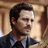

In [5]:
print(ds_train.sample_class(0))
print(ds_train.sample_classname(0))
Image.fromarray(deprocess(ds_train.sample(0)).astype(np.uint8))

1
male


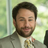

In [6]:
print(ds_val.sample_class(0))
print(ds_val.sample_classname(0))
Image.fromarray(deprocess(ds_val.sample(0)).astype(np.uint8))

In [7]:
# Initialize the preprocessing pipeline
tform = get_normalization_transform(
  means=ds_train.get_mean(per_channel=True),
  stds=ds_train.get_stddev(per_channel=True)
)

 Initializing Transformations
  FloatCastTransformation
  PerChannelSubtractionImageTransformation ([ 0.44977015  0.37664387  0.33510709])
  PerChannelDivisionImageTransformation ([ 0.28509617  0.26009572  0.25638211])


In [8]:
mean = ds_train.samples().mean(axis=(0,2,3))
stddev = ds_train.samples().std(axis=(0,2,3))
print(mean)
print(stddev)

def deprocess(data):
    data = data.copy()
    data[0] *= stddev[0]
    data[1] *= stddev[1]
    data[2] *= stddev[2]
    data[0] += mean[0]
    data[1] += mean[1]
    data[2] += mean[2]
    return data.transpose((2,1,0)) * 255

[ 0.44977015  0.37664387  0.33510709]
[ 0.28509617  0.26009572  0.25638211]


1
male


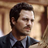

In [9]:
print(ds_train.sample_class(0))
print(ds_train.sample_classname(0))
Image.fromarray(deprocess(tform.apply(ds_train.sample(0))).astype(np.uint8))

1
male


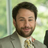

In [10]:
print(ds_val.sample_class(0))
print(ds_val.sample_classname(0))
Image.fromarray(deprocess(tform.apply(ds_val.sample(0))).astype(np.uint8))

1
male


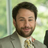

In [11]:
print(ds_val.sample_class(0))
print(ds_val.sample_classname(0))
Image.fromarray(deprocess(tform.apply(ds_val.sample(0))).astype(np.uint8))

In [12]:
import numpy.testing as npt

for x in range(48):
    for y in range(48):
        for c in range(3):
            assert (ds_train.sample(0)[c,y,x] - mean[c]) / stddev[c] == tform.apply(ds_train.sample(0))[c,y,x]

for x in range(48):
    for y in range(48):
        for c in range(3):
            npt.assert_almost_equal((tform.apply(ds_train.sample(0))[c,y,x] * stddev[c]) + mean[c], ds_train.sample(0)[c,y,x], decimal=5)

In [13]:
def show_batch(X_batch, y_batch, labels, figsize=(20,5)):
    l = X_batch.shape[0]
    fig = plt.figure(figsize=figsize)
    
    for i in range(0,l):
        ax = fig.add_subplot(1, l, i+1)
       
        X = X_batch[i]
        y = y_batch[i]
        d, h, w = X.shape
        
        im = Image.fromarray(deprocess(X).astype(np.uint8))
        im = im.transpose(PIL.Image.FLIP_TOP_BOTTOM)
        
        # Plot the image
        ax.imshow(im)
        ax.set_xlim((0, w))
        ax.set_ylim((0, h))
        
        ax.set_title(labels[y] if y in range(len(labels)) else str(y))
        
        ax.grid(True)
        # Remove tick labels
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        # Remove major ticks
        for tic in ax.xaxis.get_major_ticks():
            tic.tick1On = tic.tick2On = False
            tic.label1On = tic.label2On = False
        for tic in ax.yaxis.get_major_ticks():
            tic.tick1On = tic.tick2On = False
            tic.label1On = tic.label2On = False
        
    plt.show()

In [14]:
import theano

def show_activations(model, X, figsize=(20,1)):    
    
    for layer in model.layers:
        try:
            convout1_f = theano.function(model.inputs, [layer.output])
            act = convout1_f([X])[0] * 255
            out = act.shape
        except:
            out = None
        
        if out and len(out) > 2:
            _, f, h, w = out
            
            fig = plt.figure(figsize=figsize)
            plt.title(layer.name)
            plt.gray()
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            
            for i in range(f):
                ax = fig.add_subplot(1, f, i+1)

                im = Image.fromarray(act[0][i].transpose().astype(np.uint8))
                im = im.transpose(PIL.Image.FLIP_TOP_BOTTOM)

                # Plot the image
                ax.imshow(im)
                ax.set_xlim((0, w))
                ax.set_ylim((0, h))

                ax.grid(False)
                # Remove tick labels
                ax.set_xticklabels([])
                ax.set_yticklabels([])
                # Remove major ticks
                for tic in ax.xaxis.get_major_ticks():
                    tic.tick1On = tic.tick2On = False
                    tic.label1On = tic.label2On = False
                for tic in ax.yaxis.get_major_ticks():
                    tic.tick1On = tic.tick2On = False
                    tic.label1On = tic.label2On = False

            plt.show()

In [15]:
i = 5
X1 = MiniBatchGenerator(ds_train, ds_train.size(), tform).batch(0)[0][i]
X2 = tform.apply(ds_train.sample(i))

for x in range(48):
    for y in range(48):
        for c in range(3):
            assert X1[c,y,x] == X2[c,y,x] 

In [16]:
mb_train = MiniBatchGenerator(ds_train, 10, tform)
mb_val = MiniBatchGenerator(ds_val, 10, tform)

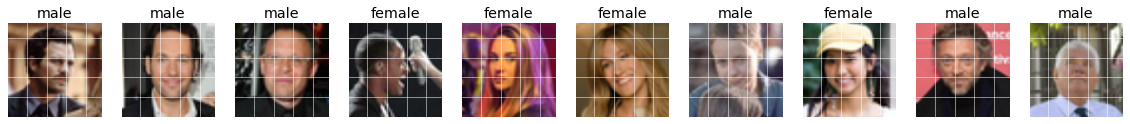

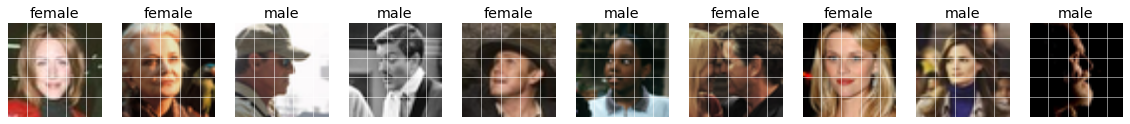

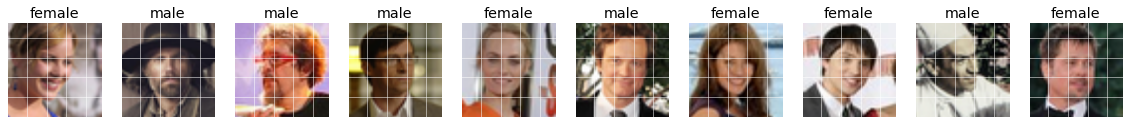

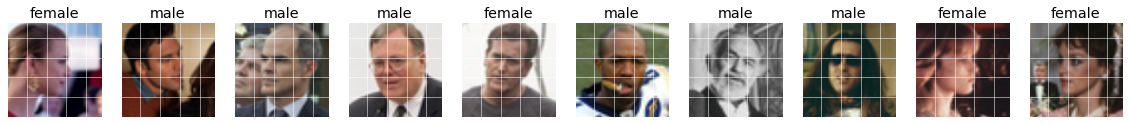

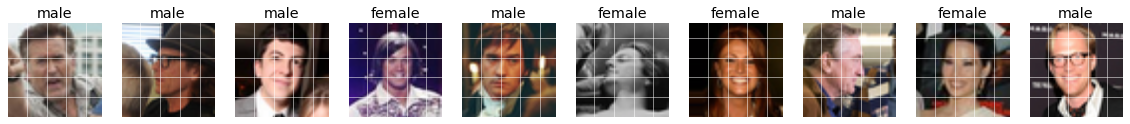

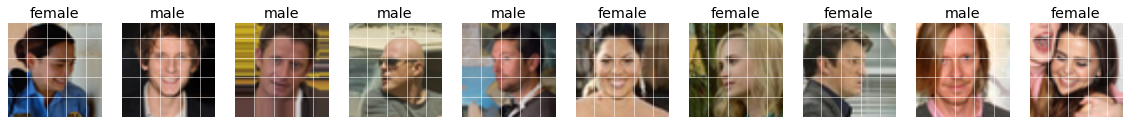

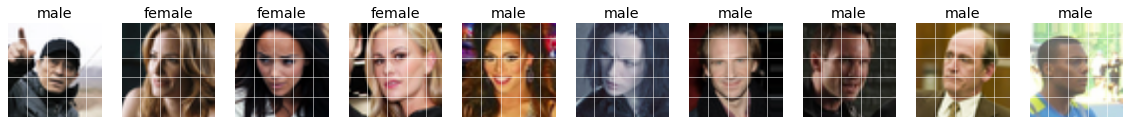

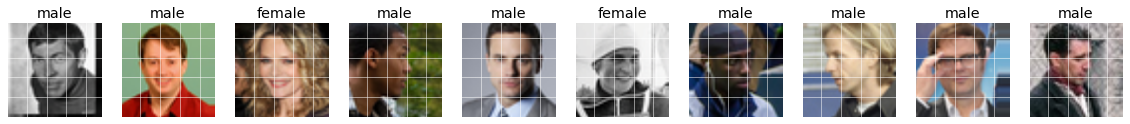

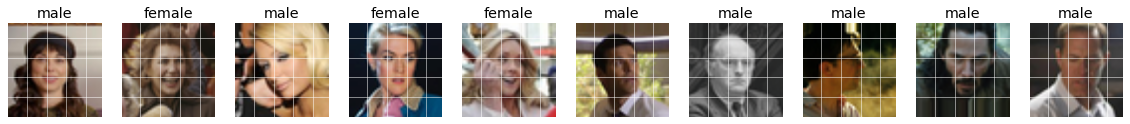

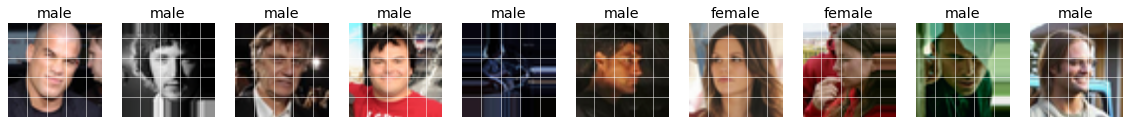

In [17]:
for i in range(10):
    X_batch, y_batch, ids = mb_train.batch(i)
    show_batch(X_batch, y_batch, ds_train.label_names)

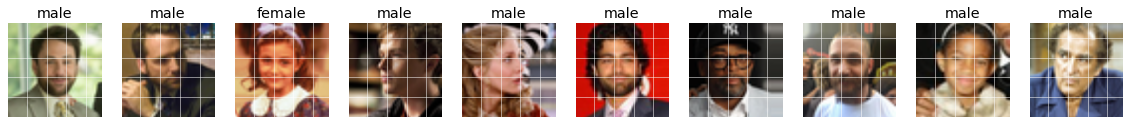

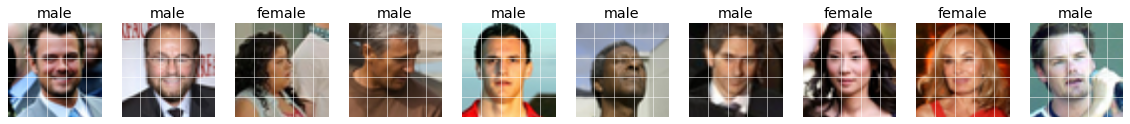

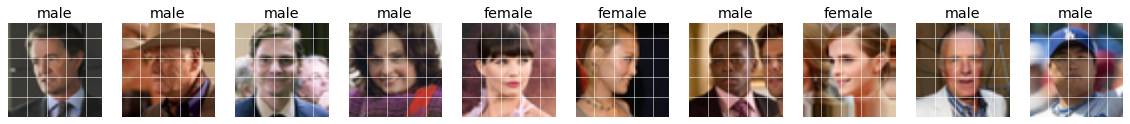

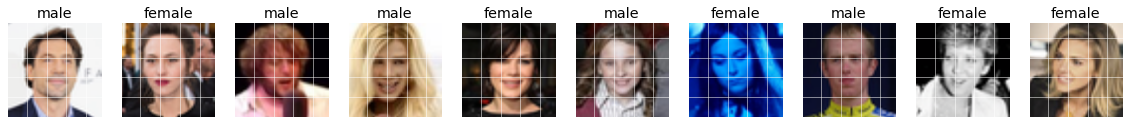

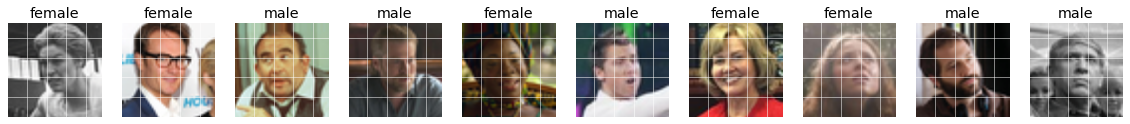

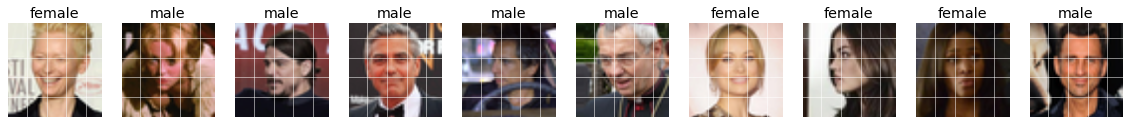

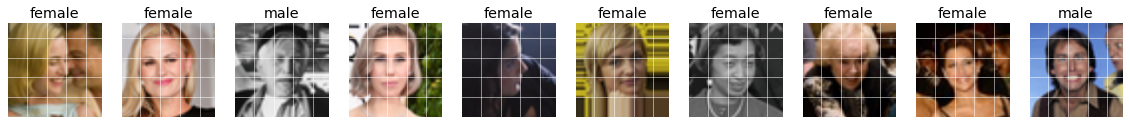

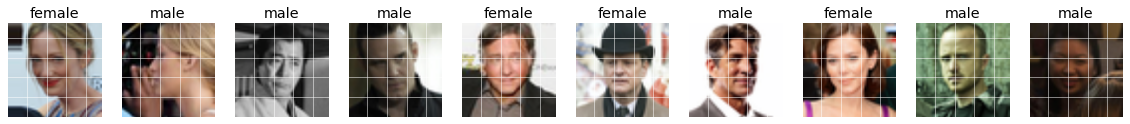

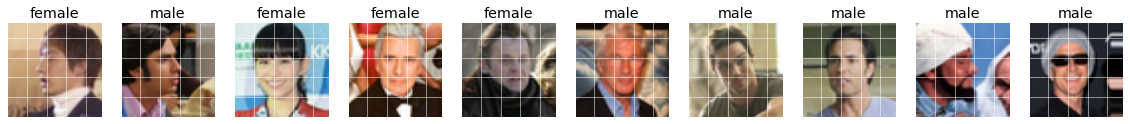

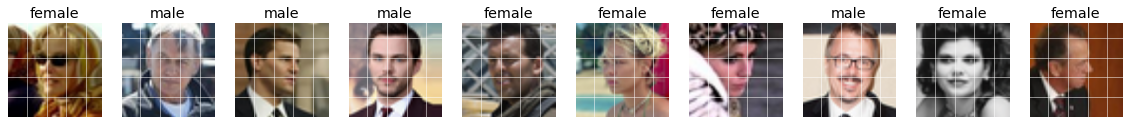

In [18]:
for i in range(10):
    X_batch, y_batch, ids = mb_val.batch(i)
    show_batch(X_batch, y_batch, ds_val.label_names)

In [19]:
print(y_batch)
np_utils.to_categorical(y_batch, mb_train.dataset.nclasses())

[0 1 1 1 0 0 0 1 0 0]


array([[ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.]])

# Verify the training progress

In [20]:
model = models.get_simple_cnn(input_shape=(3,48,48), n_classes=2)
opt = RMSprop(lr=0.005, rho=0.9, epsilon=1e-08, decay=0.999)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [21]:
i = 0
X_batch, y, ids = mb_train.batch(i)
Y_batch = np_utils.to_categorical(y, mb_train.dataset.nclasses())
model.train_on_batch(X_batch, Y_batch)

[array(0.8447967767715454, dtype=float32), array(0.5, dtype=float32)]

## Verify the weights

Let's check the weights after 1 batch. We should see values != 0 for most of the elements

In [22]:
f = 1
for i in range(1,10):
    if hasattr(model.layers[i], "W"):
        w, b = model.layers[i].get_weights()
        print(w[f])

[[[-0.0773189  -0.01813387  0.05306661]
  [ 0.07765841 -0.09192627  0.03343559]
  [-0.01743697 -0.07184946 -0.00300653]]

 [[-0.07626919  0.09344509  0.02908283]
  [ 0.04688665 -0.11035353  0.05708595]
  [ 0.02265124  0.02415485  0.0564167 ]]

 [[ 0.10099925  0.05874592 -0.12571657]
  [-0.01589987  0.03082627  0.0677217 ]
  [-0.05020548 -0.02511561  0.09399662]]

 [[ 0.07412481  0.008596    0.00669797]
  [ 0.04491092  0.05148911 -0.11258817]
  [-0.08887908  0.06545822  0.00793544]]

 [[-0.07160178  0.07735933  0.02171304]
  [-0.00140525  0.05423412 -0.05776815]
  [-0.09108216 -0.05561988 -0.02912769]]

 [[ 0.04979982  0.02453178 -0.00108801]
  [-0.0893666  -0.10021206  0.08254617]
  [-0.07921821 -0.00746205  0.05263408]]

 [[ 0.01140453 -0.08150604 -0.08308769]
  [ 0.00146834 -0.0048211   0.05987108]
  [-0.10309719 -0.06566089 -0.08557414]]

 [[-0.09789596 -0.11379044  0.06823199]
  [ 0.06262436  0.04740015 -0.02577011]
  [ 0.0023961   0.00704058 -0.05283614]]

 [[ 0.08420563  0.093915

## Verify the output activations

Now lets look at how the image is transformed through the network. We should see filtered versions of the input image. Only black images are bad and mean dead filters.

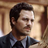

In [23]:
Image.fromarray(deprocess(X_batch[0]).astype(np.uint8))

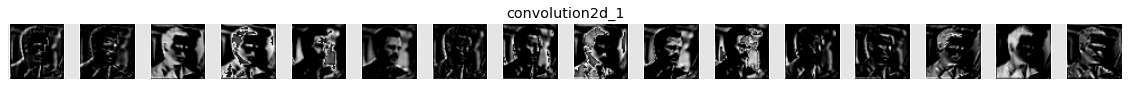

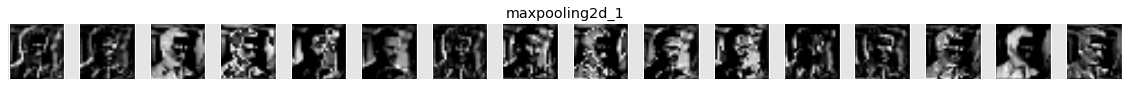

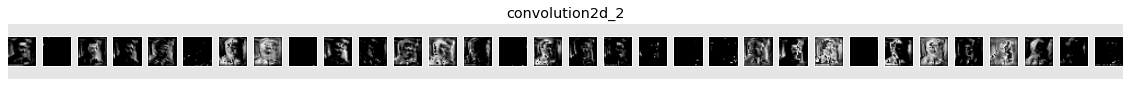

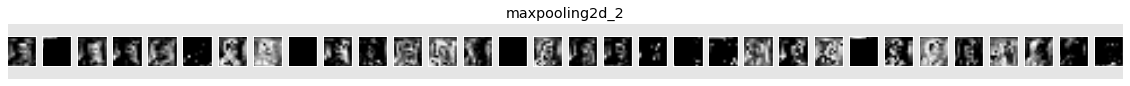

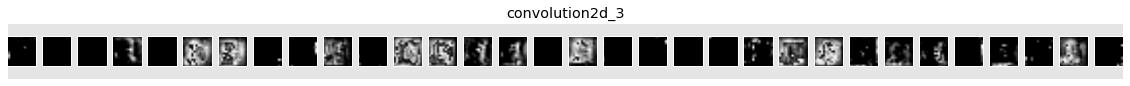

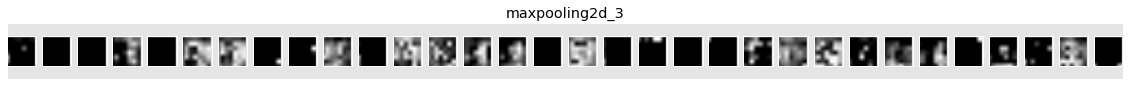

In [24]:
show_activations(model, X_batch[0])

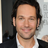

In [25]:
Image.fromarray(deprocess(X_batch[1]).astype(np.uint8))

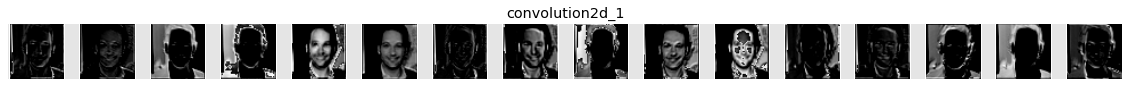

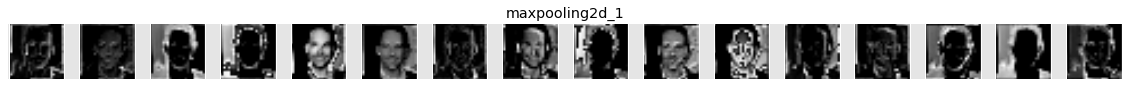

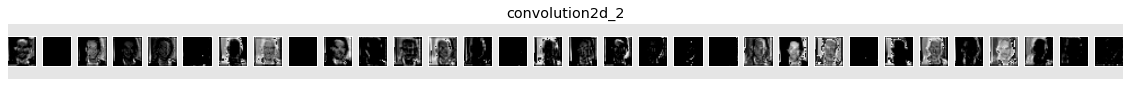

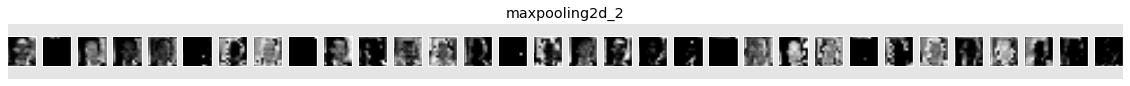

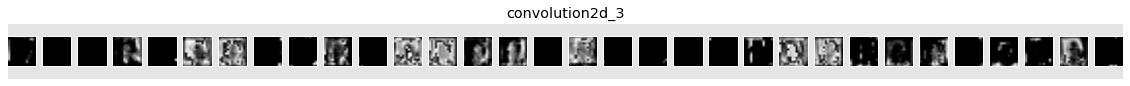

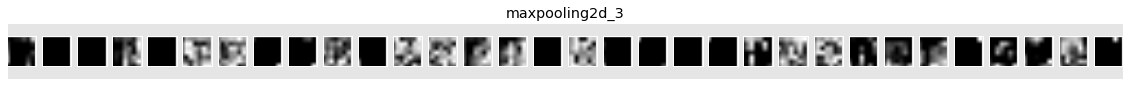

In [26]:
show_activations(model, X_batch[1])